### Course Popularity - Final Project for CSC440: Data Mining


In [75]:
from pathlib import Path
import pandas as pd
import numpy as np
import gc
import sys
import io

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# ============================================================
# 0. Load CSVs
# ============================================================
sections_file_path = Path("Data") / "Course_data" / "courses.sections.csv"
sectionsTS_file_path = Path("Data") / "Course_data" / "courses.sectionsTS.csv"

# Paths for trimmed files
sections_trimmed_path = Path("Data") / "Course_data" / "courses.sections-trimmed.csv"
sections_ts_trimmed_path = Path("Data") / "Course_data" / "courses.sectionsTS-trimmed.csv"

# Only load original full CSVs if trimmed versions don't exist
if sections_trimmed_path.exists() and sections_ts_trimmed_path.exists():
    print("Trimmed files already exist. Skipping loading of original full CSV files.")
    print("(Original files will be loaded from trimmed versions in the next cell)")
    sections_df = None
    sections_ts_df = None
else:
    sections_df = pd.read_csv(sections_file_path, low_memory=False)
    sections_ts_df = pd.read_csv(sectionsTS_file_path)

    print("\n========== Loaded Datasets ==========")
    print("courses.sections.csv info:")
    print(sections_df.info(), "\n")

    print("courses.sectionsTS.csv info:")
    print(sections_ts_df.info(), "\n")

    print("Static sections columns:", sections_df.columns)
    print("Time-series columns:", sections_ts_df.columns)

Trimmed files already exist. Skipping loading of original full CSV files.
(Original files will be loaded from trimmed versions in the next cell)


In [76]:
# ============================================================
# 0.1 Filter datasets to Spring 2025 only and export trimmed CSVs
# ============================================================

# Define paths for trimmed files
sections_ts_trimmed_path = Path("Data") / "Course_data" / "courses.sectionsTS-trimmed.csv"
sections_trimmed_path = Path("Data") / "Course_data" / "courses.sections-trimmed.csv"

# Check if trimmed files already exist
if sections_ts_trimmed_path.exists():
    print(f"Trimmed file already exists: {sections_ts_trimmed_path} (skipping creation)")
else:
    # Filter courses.sectionsTS.csv for Spring 2025
    # Note: courseInfo.year may be int or string, so we handle both
    sections_ts_trimmed = sections_ts_df[
        (sections_ts_df["courseInfo.semester"] == "Spring") & 
        (sections_ts_df["courseInfo.year"].astype(str) == "2025")
    ].copy()
    
    print(f"courses.sectionsTS.csv: {len(sections_ts_df)} rows -> {len(sections_ts_trimmed)} rows (Spring 2025 only)")
    
    # --------------------------------------------------------
    # Fix duplicate / typo columns: waitlistAvailable vs wailistAvailable
    # Merge data from typo column into correct column, then drop typo column
    # --------------------------------------------------------
    if "waitlistAvailable" in sections_ts_trimmed.columns and "wailistAvailable" in sections_ts_trimmed.columns:
        col_good = sections_ts_trimmed["waitlistAvailable"]
        col_typo = sections_ts_trimmed["wailistAvailable"]

        # Where both have values and differ, count mismatches
        both_non_null = col_good.notna() & col_typo.notna()
        mismatches = (both_non_null & (col_good != col_typo)).sum()

        print(f"\n[Data Fix] waitlistAvailable vs wailistAvailable:")
        print(f"  Rows where BOTH are non-null: {both_non_null.sum()}")
        print(f"  Rows where values MISMATCH:  {mismatches}")

        # Merge logic (intersection-style):
        # - If both non-null and equal → keep that value
        # - If only one is non-null   → use the non-null value
        # - If both non-null and different → set NaN (and rely on later checks)
        merged = np.where(
            both_non_null & (col_good == col_typo),
            col_good,                     # agree → keep
            np.where(
                col_good.notna() & ~col_typo.notna(),
                col_good,                 # only good has value
                np.where(
                    col_typo.notna() & ~col_good.notna(),
                    col_typo,             # only typo has value
                    np.nan                # mismatch or both null
                )
            )
        )

        sections_ts_trimmed["waitlistAvailable"] = merged

        # Drop the typo column
        sections_ts_trimmed = sections_ts_trimmed.drop(columns=["wailistAvailable"])

        print("  -> Merged into 'waitlistAvailable' and dropped 'wailistAvailable'.")
    else:
        print("\n[Data Fix] One or both columns 'waitlistAvailable' / 'wailistAvailable' not found; no merge performed.")
    
    # --------------------------------------------------------
    # Reorder timeseries data: group by courseInfo.classNumber
    # (maintaining first-appearance order) and sort by dateTimeRetrieved within each group
    # --------------------------------------------------------
    
    # Get unique classNumbers in order of first appearance
    unique_class_numbers_ordered = sections_ts_trimmed["courseInfo.classNumber"].drop_duplicates().tolist()
    print(f"Found {len(unique_class_numbers_ordered)} unique courses in order of first appearance")
    
    # Convert dateTimeRetrieved to datetime for proper sorting
    sections_ts_trimmed["dateTimeRetrieved"] = pd.to_datetime(sections_ts_trimmed["dateTimeRetrieved"], errors="coerce")
    
    # Create a categorical column to preserve the first-appearance order of classNumbers
    sections_ts_trimmed["classNumber_order"] = pd.Categorical(
        sections_ts_trimmed["courseInfo.classNumber"],
        categories=unique_class_numbers_ordered,
        ordered=True
    )
    
    # Sort by classNumber (first-appearance order) then by dateTimeRetrieved within each group
    sections_ts_trimmed = sections_ts_trimmed.sort_values(
        by=["classNumber_order", "dateTimeRetrieved"],
        ascending=[True, True]
    ).reset_index(drop=True)
    
    # Drop the temporary ordering column
    sections_ts_trimmed = sections_ts_trimmed.drop(columns=["classNumber_order"])
    
    print(f"Reordered timeseries data: grouped by courseInfo.classNumber, sorted by dateTimeRetrieved within each group")
    print(f"First 3 courses in order: {unique_class_numbers_ordered[:3]}")
    
    # Export trimmed and reordered sectionsTS to CSV
    sections_ts_trimmed.to_csv(sections_ts_trimmed_path, index=False)
    print(f"Saved: {sections_ts_trimmed_path}")

if sections_trimmed_path.exists():
    print(f"Trimmed file already exists: {sections_trimmed_path} (skipping creation)")
else:
    # Filter courses.sections.csv for Spring 2025
    # Note: year may be int or string, so we handle both
    sections_trimmed = sections_df[
        (sections_df["semester"] == "Spring") & 
        (sections_df["year"].astype(str) == "2025")
    ].copy()
    
    print(f"courses.sections.csv: {len(sections_df)} rows -> {len(sections_trimmed)} rows (Spring 2025 only)")
    
    # Export trimmed sections to CSV
    sections_trimmed.to_csv(sections_trimmed_path, index=False)
    print(f"Saved: {sections_trimmed_path}")

# ============================================================
# 0.2 Import the trimmed CSV files for further processing
# ============================================================

# Load the trimmed datasets
sections_df = pd.read_csv(sections_trimmed_path, low_memory=False)
sections_ts_df = pd.read_csv(sections_ts_trimmed_path)

print("\n========== Loaded Trimmed Datasets ==========")
print(f"courses.sections-trimmed.csv: {len(sections_df)} rows, {len(sections_df.columns)} columns")
print(f"courses.sectionsTS-trimmed.csv: {len(sections_ts_df)} rows, {len(sections_ts_df.columns)} columns")


Trimmed file already exists: Data/Course_data/courses.sectionsTS-trimmed.csv (skipping creation)
Trimmed file already exists: Data/Course_data/courses.sections-trimmed.csv (skipping creation)

========== Loaded Trimmed Datasets ==========
courses.sections-trimmed.csv: 7513 rows, 162 columns
courses.sectionsTS-trimmed.csv: 1060659 rows, 9 columns


In [ ]:
### ONLY RUN THIS CELL IF YOU WANT TO BUILD THE DATA QUALITY REPORT FOR A NEW TRIMMED CSV FILE ###
### OTHERWISE, SKIP THIS CELL AS RUNTIME IS LONG: 3 MIN 30 SECONDS ###

# ============================================================
# 1. Helper: Build Data Quality Report for a DataFrame
# ============================================================

def build_dq_report(df: pd.DataFrame, df_name: str):
    """
    Perform data quality checks, print all results, and return BOTH:
    - cleaned DataFrame
    - string report suitable for writing to a .txt file

    Special handling:
    - Treat 'courseInfo.classNumber' and 'courseInfo.year' as categorical,
      even if they are stored as numbers.
    """
    output = []  # collect all console lines into a list

    def log(msg=""):
        print(msg)
        output.append(str(msg))

    # ---------- Force certain numeric-looking columns to categorical ----------
    forced_categorical_cols = ["courseInfo.classNumber", "courseInfo.year"]
    for col in forced_categorical_cols:
        if col in df.columns:
            # Cast to string dtype so they behave like categorical/text
            df[col] = df[col].astype("string")

    log("\n\n============================================================")
    log(f"############  DATA QUALITY REPORT: {df_name}  ############")
    log("============================================================\n")

    # ---------- Overview ----------
    log("---- Overview ----")
    overview = pd.DataFrame({
        "n_rows": [df.shape[0]],
        "n_columns": [df.shape[1]],
        "n_duplicates": [df.duplicated().sum()]
    })
    log(overview.to_string())
    log("")

    # ---------- classNumber Uniqueness Check (for courses.sections.csv only) ----------
    # Each row in courses.sections-trimmed.csv should have a unique classNumber
    if "classNumber" in df.columns and "sectionsTS" not in df_name:
        log("---- classNumber Uniqueness Check ----")
        
        # Find duplicate classNumber values
        duplicate_mask = df["classNumber"].duplicated(keep=False)
        n_duplicates = duplicate_mask.sum()
        
        if n_duplicates == 0:
            log("All classNumber values are unique (no duplicates found)")
        else:
            log(f"WARNING: Found {n_duplicates} rows with duplicate classNumber values!")
            
            # Get the duplicate rows
            duplicate_rows = df[duplicate_mask].copy()
            duplicate_class_numbers = duplicate_rows["classNumber"].unique()
            log(f"  Number of classNumber values that appear more than once: {len(duplicate_class_numbers)}")
            
            # Show details for each duplicate classNumber
            log("\n  Duplicate classNumber details:")
            for class_num in duplicate_class_numbers[:20]:  # Limit to first 20 to avoid overwhelming output
                dup_indices = df[df["classNumber"] == class_num].index.tolist()
                log(f"    classNumber {class_num}: found at indices {dup_indices}")
            
            if len(duplicate_class_numbers) > 20:
                log(f"    ... and {len(duplicate_class_numbers) - 20} more duplicate classNumbers (truncated)")
            
            # Show sample of duplicate rows
            log("\n  Sample duplicate rows (first 10):")
            sample_cols = ["classNumber", "subjectCode", "catalogNumber", "name", "sectionType"]
            available_cols = [c for c in sample_cols if c in duplicate_rows.columns]
            log(duplicate_rows[available_cols].head(10).to_string())
        
        log("")

    # ---------- Null Summary ----------
    log("---- Null Summary (All Columns) ----")
    null_summary = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.values.astype(str),
        "null_count": df.isna().sum().values,
        "null_pct": (df.isna().mean() * 100).values
    }).sort_values("null_pct", ascending=False)
    log(null_summary.to_string(index=False))
    log("")

    # ---------- Completely Empty Columns Check ----------
    log("---- Completely Empty Columns (100% Null) ----")
    
    # Find columns where all values are null (no data at all)
    empty_cols = [col for col in df.columns if df[col].isna().all()]
    
    if len(empty_cols) == 0:
        log("No completely empty columns found - all columns have at least some data")
    else:
        log(f"WARNING: Found {len(empty_cols)} columns with NO data (100% null):")
        for i, col in enumerate(empty_cols, 1):
            log(f"  {i}. {col} (dtype: {df[col].dtype})")
        
        log(f"\n  These columns contain no useful data and could be considered for removal.")
    log("")

    # ---------- Dtype Summary ----------
    log("---- Dtype Summary ----")
    dtype_summary = (
        null_summary[["column", "dtype"]]
        .groupby("dtype")
        .agg(n_columns=("column", "count"),
             columns=("column", lambda x: ", ".join(x)))
        .reset_index()
    )
    log(dtype_summary.to_string(index=False))
    log("")

    # ---------- Numeric Summary ----------
    log("---- Numeric Summary ----")

    numeric_cols = df.select_dtypes(include=[np.number]).columns  # numeric columns
    ignore_cols = {"courseInfo.classNumber", "courseInfo.year"}   # columns to treat as categorical
    numeric_cols = [c for c in numeric_cols if c not in ignore_cols]  # filter them out

    if len(numeric_cols) > 0:
        numeric_summary = df[numeric_cols].describe().T
        numeric_summary["missing_count"] = df[numeric_cols].isna().sum()
        numeric_summary["missing_pct"] = df[numeric_cols].isna().mean() * 100
        log(numeric_summary.to_string())
    else:
        log("No numeric columns.")
    log("")

    # ---------- Categorical Summary ----------
    log("---- Categorical Summary ----")
    cat_cols = df.select_dtypes(include=["object", "category", "string"]).columns
    cat_summary_rows = []

    for col in cat_cols:
        series = df[col]

        # SPECIAL CASE: Avoid lists of large uniques value-counts in columns
        if (col in ["_id", "name", "dateTimeRetrieved", "sectionCode", "courseInfo.classNumber"] or 
            col.startswith("instructor") or col.startswith("classroom") or 
            col.startswith("timeStart") or col.startswith("timeEnd") or
            col.startswith("startDate") or col.startswith("endDate")):

            value_counts_str = "[SKIPPED - too many unique values]"
        else:
            # full list of value counts
            value_counts_str = ", ".join(
                [f"{idx}({val})" for idx, val in series.value_counts(dropna=True).items()]
            )

        cat_summary_rows.append({
            "column": col,
            "dtype": str(series.dtype),
            "n_unique": series.nunique(dropna=True),
            "missing_pct": series.isna().mean() * 100,
            "value_counts": value_counts_str
        })

    if cat_summary_rows:
        cat_summary = pd.DataFrame(cat_summary_rows)
        log(cat_summary.to_string(index=False))
    else:
        log("No categorical columns.")
    log("")

    # ---------- Type Coercion Checks ----------
    log("---- Type Coercion Checks ----")

    expected_numeric_cols = [
        "capacity", "waitlistCapacity", "reservedSeatsAvailable",
        "reservedSeatsCapacity", "year", "catalogNumber", "classNumber"
        # NOTE: we do NOT include 'courseInfo.classNumber' or 'courseInfo.year' here
    ]
    expected_datetime_cols = [
        "dateTimeRetrieved", "timeStart", "timeEnd",
        "startDate", "endDate"
    ]

    log("\nNumeric Columns Coercion Results:")
    for col in expected_numeric_cols:
        if col in df.columns:
            before = df[col].notna().sum()
            coerced = pd.to_numeric(df[col], errors="coerce")
            after = coerced.notna().sum()
            log(f"{col}: non-null before={before}, after={after}, invalid={before - after}")
            df[col] = coerced

    log("\nDatetime Columns Coercion Results:")
    for col in expected_datetime_cols:
        if col in df.columns:
            before = df[col].notna().sum()
            coerced = pd.to_datetime(df[col], errors="coerce")
            after = coerced.notna().sum()
            log(f"{col}: non-null before={before}, after={after}, invalid={before - after}")
            df[col] = coerced

    # ==========================================================================
    # DATA VALIDATION CHECKS (Specific to trimmed CSV files)
    # ==========================================================================
    log("\n---- Data Validation Checks ----")
    
    # ---------- Validation for courses.sectionsTS-trimmed.csv ----------
    if "sectionsTS" in df_name:
        log("\n[Validating courses.sectionsTS-trimmed.csv]")
        
        # 1. Check that dateTimeRetrieved is increasing for each courseInfo.classNumber
        log("\n  1. dateTimeRetrieved ordering check (must be increasing per course):")
        if "dateTimeRetrieved" in df.columns and "courseInfo.classNumber" in df.columns:
            # Convert to datetime if not already
            df["dateTimeRetrieved"] = pd.to_datetime(df["dateTimeRetrieved"], errors="coerce")
            
            # Check if dates are sorted within each course group
            violations = []
            for class_num in df["courseInfo.classNumber"].unique():
                course_data = df[df["courseInfo.classNumber"] == class_num]["dateTimeRetrieved"]
                if not course_data.is_monotonic_increasing:
                    # Find specific rows where order is violated
                    course_indices = course_data.index.tolist()
                    for i in range(1, len(course_data)):
                        if course_data.iloc[i] < course_data.iloc[i-1]:
                            violations.append({
                                "classNumber": class_num,
                                "index": course_indices[i],
                                "prev_date": course_data.iloc[i-1],
                                "curr_date": course_data.iloc[i]
                            })
            
            if len(violations) == 0:
                log("     ✓ All dateTimeRetrieved values are properly ordered (increasing) per course")
            else:
                log(f"     ⚠ WARNING: Found {len(violations)} ordering violations!")
                for v in violations[:10]:  # Show first 10
                    log(f"       classNumber {v['classNumber']}, index {v['index']}: {v['curr_date']} < {v['prev_date']}")
                if len(violations) > 10:
                    log(f"       ... and {len(violations) - 10} more violations (truncated)")
        else:
            log("     ⚠ Required columns not found for this check")
        
        # 2. Check courseInfo.semester must be only "Spring"
        log("\n  2. courseInfo.semester value check (must be 'Spring' only):")
        if "courseInfo.semester" in df.columns:
            unique_semesters = df["courseInfo.semester"].unique()
            invalid_semesters = [s for s in unique_semesters if s != "Spring"]
            if len(invalid_semesters) == 0:
                log(f"     ✓ All values are 'Spring' (unique values: {list(unique_semesters)})")
            else:
                log(f"     ⚠ WARNING: Found invalid semester values: {invalid_semesters}")
                for sem in invalid_semesters:
                    count = (df["courseInfo.semester"] == sem).sum()
                    log(f"       '{sem}': {count} rows")
        else:
            log("     ⚠ Column 'courseInfo.semester' not found")
        
        # 3. Check courseInfo.year must be only "2025"
        log("\n  3. courseInfo.year value check (must be '2025' only):")
        if "courseInfo.year" in df.columns:
            unique_years = df["courseInfo.year"].astype(str).unique()
            invalid_years = [y for y in unique_years if y != "2025"]
            if len(invalid_years) == 0:
                log(f"     ✓ All values are '2025' (unique values: {list(unique_years)})")
            else:
                log(f"     ⚠ WARNING: Found invalid year values: {invalid_years}")
                for yr in invalid_years:
                    count = (df["courseInfo.year"].astype(str) == yr).sum()
                    log(f"       '{yr}': {count} rows")
        else:
            log("     ⚠ Column 'courseInfo.year' not found")
        
        # 4. Check _id must be unique
        log("\n  4. _id uniqueness check:")
        if "_id" in df.columns:
            duplicate_ids = df["_id"].duplicated()
            n_duplicates = duplicate_ids.sum()
            if n_duplicates == 0:
                log(f"     ✓ All _id values are unique ({df['_id'].nunique()} unique values)")
            else:
                log(f"     ⚠ WARNING: Found {n_duplicates} duplicate _id values!")
                dup_id_values = df[duplicate_ids]["_id"].unique()[:10]
                log(f"       Sample duplicate _ids: {list(dup_id_values)}")
        else:
            log("     ⚠ Column '_id' not found")
    
    # ---------- Validation for courses.sections-trimmed.csv ----------
    elif "sections" in df_name and "sectionsTS" not in df_name:
        log("\n[Validating courses.sections-trimmed.csv]")
        
        # 1. Check _id must be unique
        log("\n  1. _id uniqueness check:")
        if "_id" in df.columns:
            duplicate_ids = df["_id"].duplicated()
            n_duplicates = duplicate_ids.sum()
            if n_duplicates == 0:
                log(f"     ✓ All _id values are unique ({df['_id'].nunique()} unique values)")
            else:
                log(f"     ⚠ WARNING: Found {n_duplicates} duplicate _id values!")
                dup_id_values = df[duplicate_ids]["_id"].unique()[:10]
                log(f"       Sample duplicate _ids: {list(dup_id_values)}")
        else:
            log("     ⚠ Column '_id' not found")
        
        # 2. Check academicCareer must be "Undergraduate" or "Graduate"
        log("\n  2. academicCareer value check (must be 'Undergraduate' or 'Graduate'):")
        if "academicCareer" in df.columns:
            valid_careers = {"Undergraduate", "Graduate"}
            unique_careers = set(df["academicCareer"].dropna().unique())
            invalid_careers = unique_careers - valid_careers
            if len(invalid_careers) == 0:
                log(f"     ✓ All values are valid (unique values: {unique_careers})")
            else:
                log(f"     ⚠ WARNING: Found invalid academicCareer values: {invalid_careers}")
                for career in invalid_careers:
                    count = (df["academicCareer"] == career).sum()
                    log(f"       '{career}': {count} rows")
        else:
            log("     ⚠ Column 'academicCareer' not found")
        
        # 3. Check year must be only "2025"
        log("\n  3. year value check (must be '2025' only):")
        if "year" in df.columns:
            unique_years = df["year"].astype(str).unique()
            invalid_years = [y for y in unique_years if y != "2025"]
            if len(invalid_years) == 0:
                log(f"     ✓ All values are '2025' (unique values: {list(unique_years)})")
            else:
                log(f"     ⚠ WARNING: Found invalid year values: {invalid_years}")
                for yr in invalid_years:
                    count = (df["year"].astype(str) == yr).sum()
                    log(f"       '{yr}': {count} rows")
        else:
            log("     ⚠ Column 'year' not found")
        
        # 4. Check semester must be only "Spring"
        log("\n  4. semester value check (must be 'Spring' only):")
        if "semester" in df.columns:
            unique_semesters = df["semester"].unique()
            invalid_semesters = [s for s in unique_semesters if s != "Spring"]
            if len(invalid_semesters) == 0:
                log(f"     ✓ All values are 'Spring' (unique values: {list(unique_semesters)})")
            else:
                log(f"     ⚠ WARNING: Found invalid semester values: {invalid_semesters}")
                for sem in invalid_semesters:
                    count = (df["semester"] == sem).sum()
                    log(f"       '{sem}': {count} rows")
        else:
            log("     ⚠ Column 'semester' not found")

    log(f"\n========== END OF REPORT FOR: {df_name} ==========\n")

    # Return cleaned df + FULL text output
    return df, "\n".join(output)

# ============================================================
# 2. Run Reports for Each Dataset
# ============================================================

sections_df, sections_report_txt = build_dq_report(sections_df.copy(), "courses.sections")
sections_ts_df, sectionsTS_report_txt = build_dq_report(sections_ts_df.copy(), "courses.sectionsTS")

gc.collect()

print("\n ########## Data quality analysis completed. ##########\n")

# ============================================================
# 3. SAVE REPORT TO TEXT FILE
# ============================================================

output_path = Path("Dataset-Report.txt")
with open(output_path, "w", encoding="utf-8") as f:
    f.write(sections_report_txt)
    f.write("\n\n")
    f.write(sectionsTS_report_txt)

print(f"Dataset report written to: {output_path.resolve()}")




############  DATA QUALITY REPORT: courses.sections  ############

---- Overview ----
   n_rows  n_columns  n_duplicates
0    7513        162             0

---- classNumber Uniqueness Check ----
All classNumber values are unique (no duplicates found)

---- Null Summary (All Columns) ----
                column               dtype  null_count   null_pct
              topic[4]             float64        7513 100.000000
      instructor[5][2]             float64        7513 100.000000
            timeEnd[8]             float64        7513 100.000000
        instructor[11]             float64        7513 100.000000
        instructor[12]             float64        7513 100.000000
      instructor[5][1]             float64        7513 100.000000
      instructor[4][4]             float64        7513 100.000000
      instructor[4][3]             float64        7513 100.000000
      instructor[4][2]             float64        7513 100.000000
      instructor[3][5]             float64      

In [77]:
# ===============================================================
# 2. Merge Static Course Metadata with Time-Series Observations
#    (Intersection merge on classNumber + semester + year)
#    Timeseries data is aggregated into arrays to preserve row count
# ===============================================================

# Reload fresh data from trimmed file to ensure subjectCode is preserved correctly
sections_df_fresh = pd.read_csv(sections_trimmed_path, low_memory=False)

# Make a copy of the time-series dataframe to work with
sections_ts_copy = sections_ts_df.copy()

# Convert dateTimeRetrieved to datetime for proper handling
sections_ts_copy["dateTimeRetrieved"] = pd.to_datetime(sections_ts_copy["dateTimeRetrieved"], errors="coerce")

# --------------------------------------------------------
# Find overlapping column names (excluding merge keys)
# --------------------------------------------------------
sections_cols = set(sections_df_fresh.columns)
ts_cols = set(sections_ts_copy.columns)
overlapping_cols = sections_cols.intersection(ts_cols)

# Merge key columns from TS side (will be dropped after merge, not renamed)
merge_key_cols_ts = {"courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"}
cols_to_rename = overlapping_cols - merge_key_cols_ts

print(f"Overlapping columns found: {overlapping_cols}")
print(f"Columns to rename with '-TS' suffix: {cols_to_rename}")

# Rename overlapping columns in the TS dataframe with "-TS" suffix
rename_dict = {col: f"{col}-TS" for col in cols_to_rename}
sections_ts_copy = sections_ts_copy.rename(columns=rename_dict)

# --------------------------------------------------------
# Ensure merge keys have compatible types
# --------------------------------------------------------
sections_df_fresh["classNumber"] = pd.to_numeric(sections_df_fresh["classNumber"], errors="coerce").astype("Int64")
sections_df_fresh["year"] = pd.to_numeric(sections_df_fresh["year"], errors="coerce").astype("Int64")
sections_df_fresh["semester"] = sections_df_fresh["semester"].astype(str)

sections_ts_copy["courseInfo.classNumber"] = pd.to_numeric(sections_ts_copy["courseInfo.classNumber"], errors="coerce").astype("Int64")
sections_ts_copy["courseInfo.year"] = pd.to_numeric(sections_ts_copy["courseInfo.year"], errors="coerce").astype("Int64")
sections_ts_copy["courseInfo.semester"] = sections_ts_copy["courseInfo.semester"].astype(str)

print(f"\nsections_df_fresh merge key dtypes:")
print(f"  classNumber: {sections_df_fresh['classNumber'].dtype}")
print(f"  semester: {sections_df_fresh['semester'].dtype}")
print(f"  year: {sections_df_fresh['year'].dtype}")
print(f"Unique subjectCodes in fresh data: {sections_df_fresh['subjectCode'].nunique()}")

# --------------------------------------------------------
# Aggregate timeseries data into arrays per course
# Group by courseInfo.classNumber, courseInfo.semester, courseInfo.year
# and collect all timeseries observations into lists/arrays
# --------------------------------------------------------
print("\nAggregating timeseries data into arrays per course...")

# Get columns to aggregate (all non-merge-key columns from TS)
ts_data_cols = [col for col in sections_ts_copy.columns 
                if col not in ["courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"]]

print(f"Timeseries columns to aggregate: {ts_data_cols}")

# Create aggregation dictionary - collect each column into a list
agg_dict = {col: list for col in ts_data_cols}

# Group by merge keys and aggregate into lists
ts_aggregated = sections_ts_copy.groupby(
    ["courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"],
    as_index=False
).agg(agg_dict)

# Add count of observations per course
ts_aggregated["ts_observation_count"] = ts_aggregated[ts_data_cols[0]].apply(len)

print(f"Aggregated timeseries shape: {ts_aggregated.shape}")
print(f"Sample observation counts: {ts_aggregated['ts_observation_count'].head().tolist()}")

# --------------------------------------------------------
# Perform intersection merge on classNumber + semester + year
# --------------------------------------------------------
df = sections_df_fresh.merge(
    ts_aggregated,
    left_on=["classNumber", "semester", "year"],
    right_on=["courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"],
    how="inner"  # intersection merge
)

# Drop duplicate key columns from the TS side
df = df.drop(columns=["courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"])

print(f"\n========== Merge Results ==========")
print(f"Original sections_df rows: {len(sections_df_fresh)}")
print(f"Merged dataframe rows: {len(df)}")
print(f"Merged dataframe columns: {len(df.columns)}")

# Show columns that came from TS file (with -TS suffix or ts_ prefix)
print(f"\nColumns with '-TS' suffix: {[c for c in df.columns if c.endswith('-TS')]}")
print(f"Timeseries array columns: {ts_data_cols}")
print(f"Observation count column: ts_observation_count")

# Display sample to verify merge success
print("\n========== Merged Dataset Sample ==========")
sample_cols = ["classNumber", "subjectCode", "catalogNumber", "semester", "year", "capacity", "ts_observation_count"]
available_sample_cols = [c for c in sample_cols if c in df.columns]
print(df[available_sample_cols].head(10))

# Show a sample of the nested timeseries data
print("\n========== Sample Timeseries Arrays (first course) ==========")
if len(df) > 0:
    first_row = df.iloc[0]
    print(f"Course: {first_row['classNumber']} - {first_row['subjectCode']} {first_row.get('catalogNumber', 'N/A')}")
    print(f"Number of timeseries observations: {first_row['ts_observation_count']}")
    if "dateTimeRetrieved" in df.columns:
        print(f"dateTimeRetrieved (first 5): {first_row['dateTimeRetrieved'][:5]}")
    if "seatsAvailable" in df.columns:
        print(f"seatsAvailable (first 5): {first_row['seatsAvailable'][:5]}")
    if "status" in df.columns:
        print(f"status (first 5): {first_row['status'][:5]}")


Overlapping columns found: {'_id', 'reservedSeatsAvailable', 'dateTimeRetrieved'}
Columns to rename with '-TS' suffix: {'_id', 'reservedSeatsAvailable', 'dateTimeRetrieved'}

sections_df_fresh merge key dtypes:
  classNumber: Int64
  semester: object
  year: Int64
Unique subjectCodes in fresh data: 130

Aggregating timeseries data into arrays per course...
Timeseries columns to aggregate: ['dateTimeRetrieved-TS', '_id-TS', 'seatsAvailable', 'status', 'waitlistAvailable', 'reservedSeatsAvailable-TS']
Aggregated timeseries shape: (7528, 10)
Sample observation counts: [148, 148, 148, 148, 44]

========== Merge Results ==========
Original sections_df rows: 7513
Merged dataframe rows: 7513
Merged dataframe columns: 169

Columns with '-TS' suffix: ['dateTimeRetrieved-TS', '_id-TS', 'reservedSeatsAvailable-TS']
Timeseries array columns: ['dateTimeRetrieved-TS', '_id-TS', 'seatsAvailable', 'status', 'waitlistAvailable', 'reservedSeatsAvailable-TS']
Observation count column: ts_observation_coun

Expanding timeseries arrays to flat dataframe...
Timeseries array columns to expand: ['seatsAvailable', 'status', 'waitlistAvailable', 'dateTimeRetrieved-TS', '_id-TS', 'reservedSeatsAvailable-TS']
Metadata columns to merge back: 161 columns
Expanded dataframe shape: (1060419, 167)
Course-level dataframe shape: (7513, 169)
Total timeseries observations: 1,060,419

Note: 'dateTimeRetrieved' in df_flat is the actual timeseries datetime (from sectionsTS)


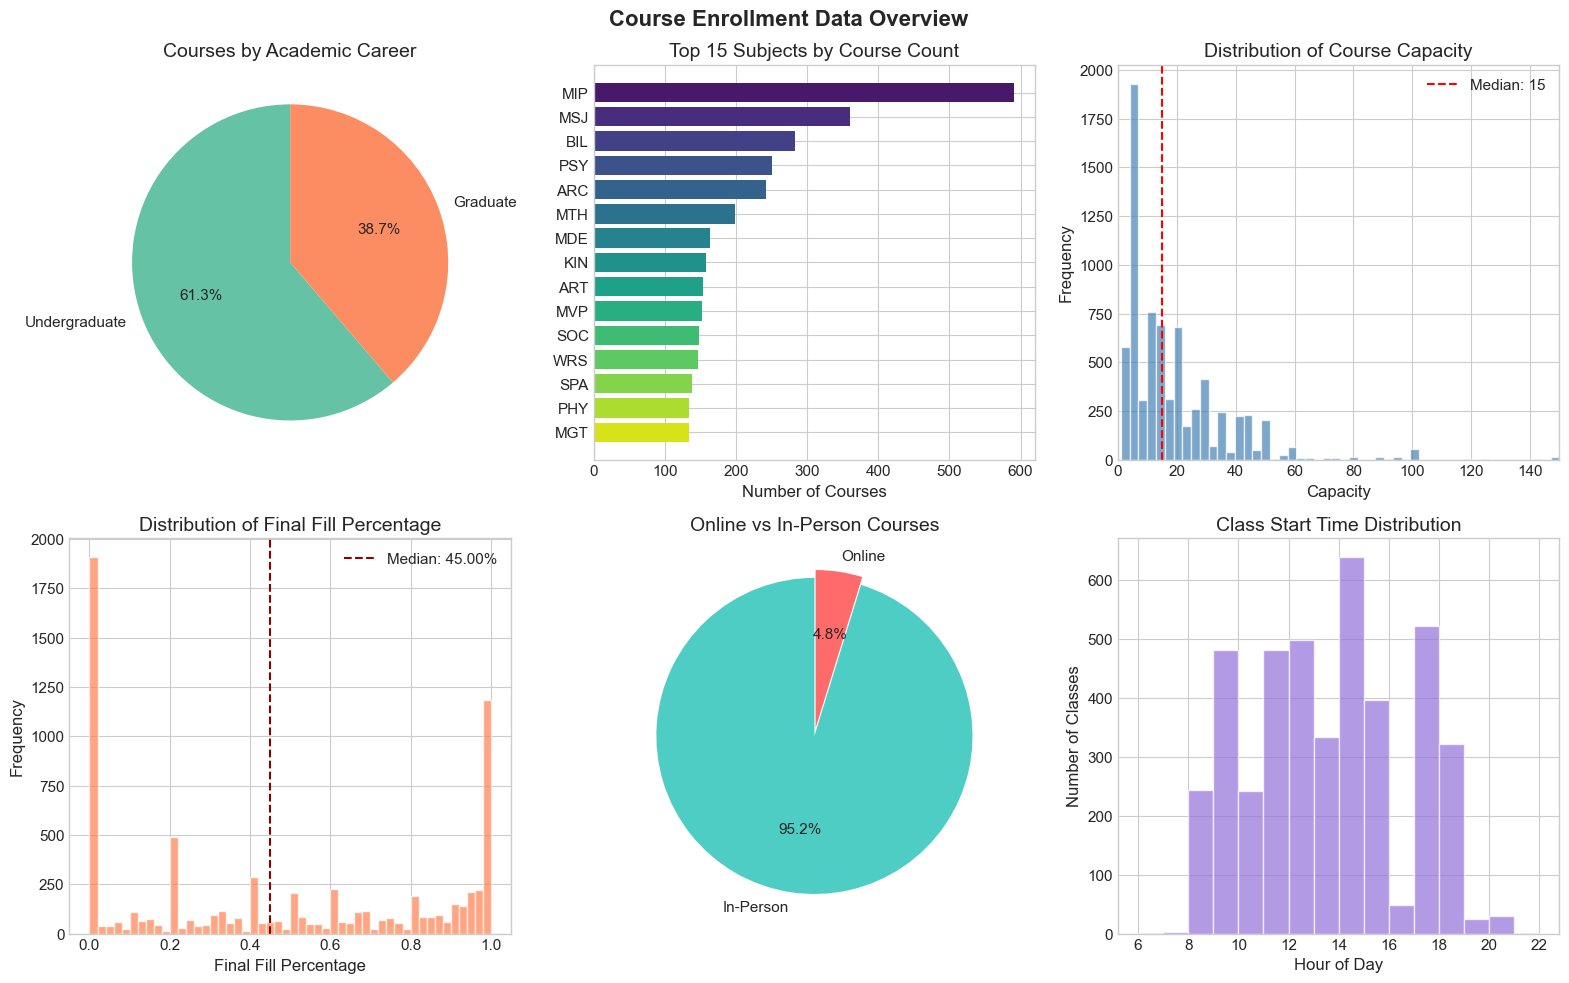


📊 Data Summary:
   Total courses: 7,513
   Total timeseries observations: 1,060,419
   Subject areas: 130
   Date range: 2024-11-04 to 2025-04-11


In [81]:
# ===============================================================
# 2.1 Expand Array Data for Timeseries Analysis
# ===============================================================
# The merged df has timeseries data as arrays. For feature engineering and
# modeling, we need to expand this to one row per observation.
#
# NOTE: 
# - "dateTimeRetrieved" (from sections_df) = single poll timestamp (not relevant for timeseries)
# - "dateTimeRetrieved-TS" (from sections_ts_df) = actual timeseries timestamps (IMPORTANT)

print("Expanding timeseries arrays to flat dataframe...")

# Identify array columns (timeseries data stored as lists)
# These are the columns that contain lists from the aggregation
ts_array_cols = ['seatsAvailable', 'status', 'waitlistAvailable', 
                 'dateTimeRetrieved-TS', '_id-TS', 'reservedSeatsAvailable-TS']

# Check which columns actually exist in df
existing_ts_cols = [col for col in ts_array_cols if col in df.columns]
print(f"Timeseries array columns to expand: {existing_ts_cols}")

# Get non-array columns (course metadata) - exclude ts_observation_count, array columns,
# and the original dateTimeRetrieved (which is just a single poll timestamp, not timeseries data)
excluded_cols = set(existing_ts_cols) | {'ts_observation_count', 'dateTimeRetrieved'}
metadata_cols = [col for col in df.columns if col not in excluded_cols]
print(f"Metadata columns to merge back: {len(metadata_cols)} columns")

# Create expanded dataframe by exploding array columns
# Use pd.DataFrame.explode with multiple columns (pandas >= 1.3.0)
df_expanded = df[['classNumber'] + existing_ts_cols].copy()

# Explode all array columns at once
df_expanded = df_expanded.explode(existing_ts_cols, ignore_index=True)

# Rename columns: dateTimeRetrieved-TS becomes dateTimeRetrieved (the actual timeseries datetime)
rename_map = {
    'dateTimeRetrieved-TS': 'dateTimeRetrieved',  # This is the actual timeseries datetime
    '_id-TS': '_id_ts',
    'reservedSeatsAvailable-TS': 'reservedSeatsAvailable_ts'
}
df_expanded = df_expanded.rename(columns={k: v for k, v in rename_map.items() if k in df_expanded.columns})

# Convert data types
if 'dateTimeRetrieved' in df_expanded.columns:
    df_expanded['dateTimeRetrieved'] = pd.to_datetime(df_expanded['dateTimeRetrieved'], errors='coerce')
if 'seatsAvailable' in df_expanded.columns:
    df_expanded['seatsAvailable'] = pd.to_numeric(df_expanded['seatsAvailable'], errors='coerce')
if 'waitlistAvailable' in df_expanded.columns:
    df_expanded['waitlistAvailable'] = pd.to_numeric(df_expanded['waitlistAvailable'], errors='coerce')
if 'reservedSeatsAvailable_ts' in df_expanded.columns:
    df_expanded['reservedSeatsAvailable_ts'] = pd.to_numeric(df_expanded['reservedSeatsAvailable_ts'], errors='coerce')

# Merge back with metadata (course info) - excludes the irrelevant dateTimeRetrieved from sections_df
df_flat = df_expanded.merge(df[metadata_cols], on='classNumber', how='left')

# Sort by classNumber and timestamp (dateTimeRetrieved is now the timeseries datetime)
if 'dateTimeRetrieved' in df_flat.columns:
    df_flat = df_flat.sort_values(['classNumber', 'dateTimeRetrieved']).reset_index(drop=True)
else:
    df_flat = df_flat.sort_values(['classNumber']).reset_index(drop=True)

print(f"Expanded dataframe shape: {df_flat.shape}")
print(f"Course-level dataframe shape: {df.shape}")
print(f"Total timeseries observations: {len(df_flat):,}")
print(f"\nNote: 'dateTimeRetrieved' in df_flat is the actual timeseries datetime (from sectionsTS)")

# ===============================================================
# VISUALIZATION 1: Data Overview & Distribution
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Course Enrollment Data Overview', fontsize=16, fontweight='bold')

# 1. Distribution of courses by academic career (use course-level df)
ax1 = axes[0, 0]
career_counts = df['academicCareer'].value_counts()
colors = sns.color_palette("Set2", len(career_counts))
ax1.pie(career_counts.values, labels=career_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Courses by Academic Career')

# 2. Top 15 subjects by number of courses (use course-level df)
ax2 = axes[0, 1]
subject_counts = df['subjectCode'].value_counts().head(15)
bars = ax2.barh(subject_counts.index, subject_counts.values, color=sns.color_palette("viridis", 15))
ax2.set_xlabel('Number of Courses')
ax2.set_title('Top 15 Subjects by Course Count')
ax2.invert_yaxis()

# 3. Capacity distribution (use course-level df)
ax3 = axes[0, 2]
capacity_data = df['capacity'].dropna()
# Use 99th percentile as upper limit to focus on main distribution, cap at 400
x_max = min(capacity_data.quantile(0.99), 400)
ax3.hist(capacity_data[capacity_data <= x_max], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax3.axvline(df['capacity'].median(), color='red', linestyle='--', label=f'Median: {df["capacity"].median():.0f}')
ax3.set_xlabel('Capacity')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Course Capacity')
ax3.set_xlim(0, x_max)
ax3.legend()

# 4. Final Fill Percentage distribution (compute from last observation per course)
ax4 = axes[1, 0]
# Get final seats available for each course (last element in array)
final_seats = df.apply(lambda row: row['seatsAvailable'][-1] if len(row['seatsAvailable']) > 0 else np.nan, axis=1)
final_fill_pct = (df['capacity'] - final_seats) / df['capacity'].replace(0, np.nan)
fill_pct_clean = final_fill_pct.dropna()
fill_pct_clean = fill_pct_clean[(fill_pct_clean >= 0) & (fill_pct_clean <= 1.5)]
ax4.hist(fill_pct_clean, bins=50, color='coral', edgecolor='white', alpha=0.7)
ax4.axvline(fill_pct_clean.median(), color='darkred', linestyle='--', label=f'Median: {fill_pct_clean.median():.2%}')
ax4.set_xlabel('Final Fill Percentage')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Final Fill Percentage')
ax4.legend()

# 5. Online vs In-Person (use course-level df)
ax5 = axes[1, 1]
# Check if classroom contains "Online"
is_online = df['classroom'].fillna("").str.contains("Online", case=False)
online_counts = is_online.value_counts()
labels = ['In-Person', 'Online'] if False in online_counts.index else ['Online', 'In-Person']
ax5.pie(online_counts.values, labels=labels, autopct='%1.1f%%', colors=['#4ECDC4', '#FF6B6B'], startangle=90, explode=[0, 0.05])
ax5.set_title('Online vs In-Person Courses')

# 6. Time of day distribution (class start times) - use course-level df
ax6 = axes[1, 2]
temp_timestart = pd.to_datetime(df['timeStart'], errors='coerce')
start_hours = temp_timestart.dt.hour.dropna()
ax6.hist(start_hours, bins=range(6, 23), color='mediumpurple', edgecolor='white', alpha=0.7)
ax6.set_xlabel('Hour of Day')
ax6.set_ylabel('Number of Classes')
ax6.set_title('Class Start Time Distribution')
ax6.set_xticks(range(6, 23, 2))

plt.tight_layout()
plt.show()

# Get date range from the expanded timeseries
min_date = df_flat['dateTimeRetrieved'].min()
max_date = df_flat['dateTimeRetrieved'].max()

print(f"\n📊 Data Summary:")
print(f"   Total courses: {len(df):,}")
print(f"   Total timeseries observations: {len(df_flat):,}")
print(f"   Subject areas: {df['subjectCode'].nunique()}")
print(f"   Date range: {min_date.date()} to {max_date.date()}")


In [ ]:
# ===============================================================
# 3. Feature Engineering (using expanded df_flat)
# ===============================================================

# Work with the expanded flat dataframe for timeseries feature engineering
df_model = df_flat.copy()

# ---- Temporal Features ----
df_model["days_since_start"] = df_model.groupby("classNumber")["dateTimeRetrieved"] \
                           .transform(lambda x: (x - x.min()).dt.total_seconds() / 86400)

df_model["hour"] = df_model["dateTimeRetrieved"].dt.hour
df_model["day_of_week"] = df_model["dateTimeRetrieved"].dt.dayofweek # 0=Monday, ..., 6=Sunday
df_model["is_weekend"] = df_model["day_of_week"].isin([5,6]).astype(int) # 5=Saturday, 6=Sunday

# Cyclical time encoding
df_model["hour_sin"] = np.sin(2 * np.pi * df_model["hour"] / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model["hour"] / 24)
df_model["dow_sin"] = np.sin(2 * np.pi * df_model["day_of_week"] / 7)
df_model["dow_cos"] = np.cos(2 * np.pi * df_model["day_of_week"] / 7)

# ---- Enrollment Features ----
df_model["seats_taken"] = df_model["capacity"] - df_model["seatsAvailable"]
df_model["fill_pct"] = df_model["seats_taken"] / df_model["capacity"].replace(0, np.nan)

df_model["waitlist_ratio"] = df_model["waitlistAvailable"] / df_model["waitlistCapacity"].replace(0, np.nan)

# ---- Velocity Metrics ----
df_model["fill_velocity_per_day"] = df_model.groupby("classNumber")["fill_pct"].diff() / \
                              df_model.groupby("classNumber")["days_since_start"].diff()

df_model["rolling_velocity_6h"] = df_model.groupby("classNumber")["fill_pct"].transform(
    lambda x: x.diff().rolling(6).mean()
)

# Fill acceleration (rate of change of velocity) - REQUIRED per proposal
df_model["fill_acceleration"] = df_model.groupby("classNumber")["fill_velocity_per_day"].diff()

# Observation sequence number per course - REQUIRED per proposal
df_model["observation_sequence"] = df_model.groupby("classNumber").cumcount() + 1

# Seats remaining percentage - REQUIRED per proposal
df_model["seats_remaining_pct"] = df_model["seatsAvailable"] / df_model["capacity"].replace(0, np.nan)

# ---- Course-Level Features ----
# Convert catalogNumber to numeric (some may be strings like "220" or alphanumeric)
df_model["catalogNumber"] = pd.to_numeric(df_model["catalogNumber"], errors="coerce")
df_model["course_level"] = df_model["catalogNumber"] // 100
# Check if classroom contains "Online" (handles "Online Instruction ONL" etc.)
df_model["is_online"] = df_model["classroom"].fillna("").str.contains("Online", case=False).astype(int)

df_model["timeStart"] = pd.to_datetime(df_model["timeStart"], errors="coerce")
df_model["early_morning"] = (df_model["timeStart"].dt.hour < 10).astype(int)
df_model["evening"] = (df_model["timeStart"].dt.hour >= 17).astype(int)

print(f"Feature engineering complete. DataFrame shape: {df_model.shape}")
gc.collect()
print("Saving df_model to CSV file: courses.sectionsTS-with-features.csv")
df_model.to_csv("courses.sectionsTS-with-features.csv", index=False)

Feature engineering complete. DataFrame shape: (1060419, 187)


In [84]:
# ===============================================================
# 4. Modeling Dataset Construction (using df_model)
# ===============================================================
target = "fill_pct"

feature_cols = [
    "days_since_start", "hour_sin", "hour_cos", "dow_sin", "dow_cos",
    "is_weekend", "seats_taken", "capacity", "waitlist_ratio",
    "fill_velocity_per_day", "rolling_velocity_6h",
    "fill_acceleration", "observation_sequence", "seats_remaining_pct",  # Added per proposal
    "course_level", "is_online", "early_morning", "evening"
]

# Preserve subjectCode before one-hot encoding (needed for popularity metrics later)
# Use a name that won't be picked up by the feature_cols filter
df_model["original_subjectCode"] = df_model["subjectCode"].copy()

# One-hot encode subjectCode & academicCareer
df_model = pd.get_dummies(df_model, columns=["subjectCode", "academicCareer"], drop_first=True)

feature_cols.extend([col for col in df_model.columns if col.startswith("subjectCode_")])
feature_cols.extend([col for col in df_model.columns if col.startswith("academicCareer_")])

df_model = df_model.dropna(subset=[target])

X = df_model[feature_cols].copy()
y = df_model[target].copy()

# Replace infinite values with NaN, then fill with 0
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"Features: {len(feature_cols)} columns")
print(f"Training samples: {len(X)}")

Features: 148 columns
Training samples: 1060419


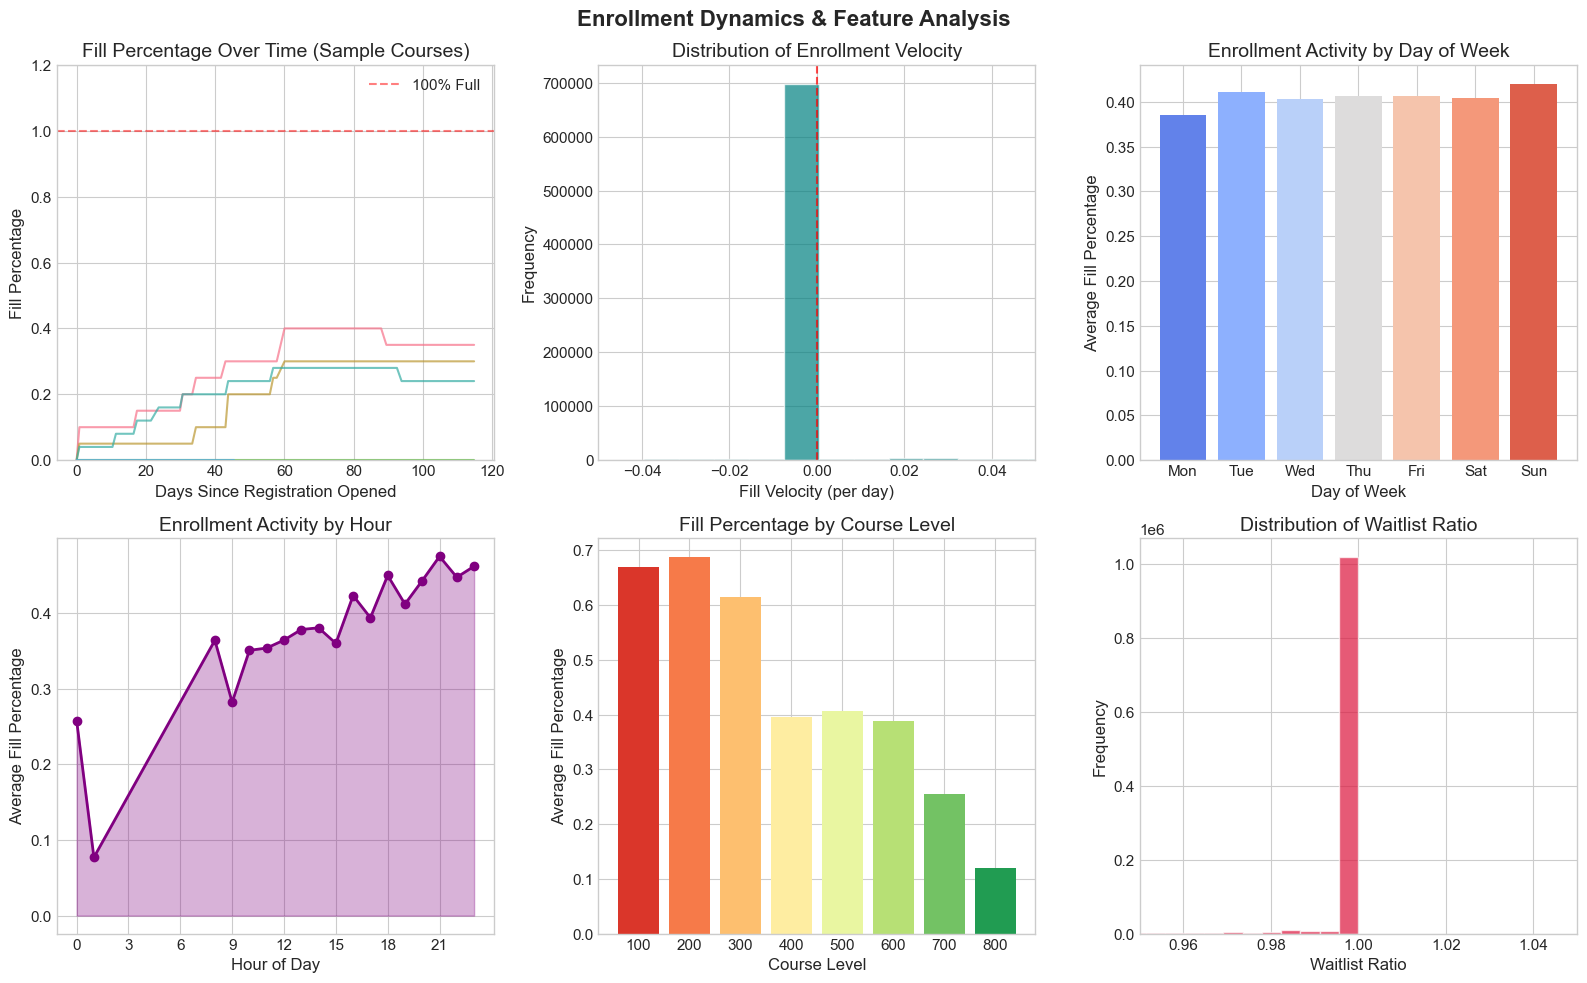


📈 Enrollment Insights:
   Average fill percentage: 42.8%
   Courses at full capacity: 1,144
   Courses with waitlists: 1,060,417


In [88]:
# ===============================================================
# VISUALIZATION 2: Enrollment Dynamics & Feature Analysis (using df_model)
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Enrollment Dynamics & Feature Analysis', fontsize=16, fontweight='bold')

# 1. Fill percentage over time (sampled courses)
ax1 = axes[0, 0]
sample_courses = df_model['classNumber'].unique()[:5]
for course in sample_courses:
    course_data = df_model[df_model['classNumber'] == course].sort_values('days_since_start')
    if len(course_data) > 5:
        ax1.plot(course_data['days_since_start'], course_data['fill_pct'], alpha=0.7, linewidth=1.5)
ax1.set_xlabel('Days Since Registration Opened')
ax1.set_ylabel('Fill Percentage')
ax1.set_title('Fill Percentage Over Time (Sample Courses)')
ax1.set_ylim(0, 1.2)
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='100% Full')
ax1.legend()

# 2. Fill velocity distribution  (x-axis limited to -0.2 to 0.2)
ax2 = axes[0, 1]
velocity_clean = df_model['fill_velocity_per_day'].replace([np.inf, -np.inf], np.nan).dropna()
velocity_clean = velocity_clean[(velocity_clean >= -0.2) & (velocity_clean <= 0.2)]
ax2.hist(velocity_clean, bins=50, color='teal', edgecolor='white', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Fill Velocity (per day)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Enrollment Velocity')
ax2.set_xlim(-0.05, 0.05)

# 3. Enrollment by day of week
ax3 = axes[0, 2]
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_activity = df_model.groupby('day_of_week')['fill_pct'].mean()
bars = ax3.bar(dow_names, dow_activity.values, color=sns.color_palette("coolwarm", 7))
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('Average Fill Percentage')
ax3.set_title('Enrollment Activity by Day of Week')

# 4. Enrollment by hour of day
ax4 = axes[1, 0]
hourly_activity = df_model.groupby('hour')['fill_pct'].mean()
ax4.plot(hourly_activity.index, hourly_activity.values, marker='o', color='purple', linewidth=2)
ax4.fill_between(hourly_activity.index, hourly_activity.values, alpha=0.3, color='purple')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Average Fill Percentage')
ax4.set_title('Enrollment Activity by Hour')
ax4.set_xticks(range(0, 24, 3))

# 5. Course level vs fill percentage
ax5 = axes[1, 1]
level_fill = df_model.groupby('course_level')['fill_pct'].mean().dropna()
level_fill = level_fill[(level_fill.index >= 1) & (level_fill.index <= 8)]
colors = sns.color_palette("RdYlGn", len(level_fill))
bars = ax5.bar([f'{int(x)}00' for x in level_fill.index], level_fill.values, color=colors)
ax5.set_xlabel('Course Level')
ax5.set_ylabel('Average Fill Percentage')
ax5.set_title('Fill Percentage by Course Level')

# 6. Waitlist ratio distribution (x-axis starts at 0.8)
ax6 = axes[1, 2]
waitlist_clean = df_model['waitlist_ratio'].replace([np.inf, -np.inf], np.nan).dropna()
waitlist_clean = waitlist_clean[(waitlist_clean >= 0.8) & (waitlist_clean <= 2)]
ax6.hist(waitlist_clean, bins=40, color='crimson', edgecolor='white', alpha=0.7)
ax6.set_xlabel('Waitlist Ratio')
ax6.set_ylabel('Frequency')
ax6.set_title('Distribution of Waitlist Ratio')
ax6.set_xlim(0.95, 1.05)

plt.tight_layout()
plt.show()

print("\n📈 Enrollment Insights:")
print(f"   Average fill percentage: {df_model['fill_pct'].mean():.1%}")
print(f"   Courses at full capacity: {(df_model.groupby('classNumber')['fill_pct'].last() >= 1.0).sum():,}")
print(f"   Courses with waitlists: {(df_model['waitlist_ratio'] > 0).sum():,}")


In [89]:
# ===============================================================
# 5. Time-Series Cross Validation (No Leakage)
# ===============================================================
tscv = TimeSeriesSplit(n_splits=5)

mae_scores, rmse_scores, r2_scores = [], [], []

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist"
)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, preds))
    rmse_scores.append(mean_squared_error(y_test, preds, squared=False))
    r2_scores.append(r2_score(y_test, preds))


print("\n========== Time-Series CV Results ==========")
print("MAE:", np.mean(mae_scores))
print("RMSE:", np.mean(rmse_scores))
print("R²:", np.mean(r2_scores))


========== Time-Series CV Results ==========
MAE: 0.0037763411595181824
RMSE: 0.03201393792270889
R²: 0.9938307729233982


In [90]:
# ===============================================================
# 6. Business-Relevant Metric: ±5% Tolerance Accuracy
# ===============================================================
model.fit(X, y)
preds = model.predict(X)

tolerance = 0.05
within_tol = np.mean(np.abs(preds - y) <= tolerance)

print("\nWithin ±5% tolerance accuracy:", within_tol)


Within ±5% tolerance accuracy: 0.9983402787011549


In [91]:
# ===============================================================
# 7. Stage-Specific Performance Evaluation (per proposal requirements)
# ===============================================================
# Evaluate error separately for Early/Mid/Late stages

# Define stages based on fill percentage (using df_model)
df_model["stage"] = pd.cut(
    df_model["fill_pct"], 
    bins=[-np.inf, 0.25, 0.75, np.inf], 
    labels=["Early (0-25%)", "Mid (25-75%)", "Late (75-100%)"]
)

# Get predictions for the full dataset
full_preds = model.predict(X)

# Add predictions and actual values for analysis
eval_df = pd.DataFrame({
    "actual": y.values,
    "predicted": full_preds,
    "stage": df_model.loc[y.index, "stage"].values
})
eval_df["error"] = np.abs(eval_df["predicted"] - eval_df["actual"])

# Calculate metrics by stage
print("\n========== Stage-Specific Performance ==========")
for stage in ["Early (0-25%)", "Mid (25-75%)", "Late (75-100%)"]:
    stage_data = eval_df[eval_df["stage"] == stage]
    if len(stage_data) > 0:
        stage_mae = stage_data["error"].mean()
        stage_rmse = np.sqrt((stage_data["error"]**2).mean())
        stage_within_tol = (stage_data["error"] <= 0.05).mean()
        print(f"\n{stage}:")
        print(f"  Samples: {len(stage_data):,}")
        print(f"  MAE: {stage_mae:.4f}")
        print(f"  RMSE: {stage_rmse:.4f}")
        print(f"  Within ±5%: {stage_within_tol:.2%}")



========== Stage-Specific Performance ==========

Early (0-25%):
  Samples: 463,599
  MAE: 0.0024
  RMSE: 0.0361
  Within ±5%: 99.62%

Mid (25-75%):
  Samples: 275,708
  MAE: 0.0014
  RMSE: 0.0021
  Within ±5%: 100.00%

Late (75-100%):
  Samples: 321,112
  MAE: 0.0010
  RMSE: 0.0018
  Within ±5%: 100.00%


In [92]:
# ===============================================================
# 8. Popularity Metrics for Ranking Courses (using df_model)
# ===============================================================
course_groups = df_model.groupby("classNumber")

# Calculate Time-to-Fill Score (days to reach 90% capacity)
def calc_time_to_fill(group, threshold=0.90):
    """Calculate days to reach threshold fill percentage"""
    filled = group[group["fill_pct"] >= threshold]
    if len(filled) > 0:
        return filled["days_since_start"].min()
    return np.nan  # Never reached threshold

time_to_fill = df_model.groupby("classNumber").apply(calc_time_to_fill).reset_index()
time_to_fill.columns = ["classNumber", "time_to_fill_days"]

popularity = pd.DataFrame({
    "classNumber": course_groups["classNumber"].first(),
    "subjectCode": course_groups["original_subjectCode"].first(),
    "catalogNumber": course_groups["catalogNumber"].first(),
    "course_level": course_groups["course_level"].first(),
    
    # Popularity Scores (per proposal requirements):
    "final_fill_rate": course_groups["fill_pct"].last(),
    "fill_velocity_score": course_groups["fill_velocity_per_day"].mean(),
    "early_rush_score": course_groups["fill_pct"].nth(3),  # first few hours
    "waitlist_demand_score": course_groups["waitlist_ratio"].max()
})

# Merge Time-to-Fill Score
popularity = popularity.merge(time_to_fill, on="classNumber", how="left")

# Normalize time_to_fill to a score (faster fill = higher score)
# Invert so that lower time = higher score
max_days = popularity["time_to_fill_days"].max()
popularity["time_to_fill_score"] = 1 - (popularity["time_to_fill_days"] / max_days)
popularity["time_to_fill_score"] = popularity["time_to_fill_score"].fillna(0)

# Replace inf/-inf with NaN, then fill with 0 for composite calculation
popularity = popularity.replace([np.inf, -np.inf], np.nan)
popularity = popularity.fillna(0)

# Composite Score (updated weights to include time_to_fill)
popularity["popularity_score"] = (
    0.30 * popularity["final_fill_rate"] +
    0.25 * popularity["fill_velocity_score"] +
    0.20 * popularity["time_to_fill_score"] +  # Added per proposal
    0.15 * popularity["waitlist_demand_score"] +
    0.10 * popularity["early_rush_score"]
)

print(f"Popularity metrics calculated for {len(popularity)} courses")
print(f"\nPopularity metrics include:")
print("  - Final Fill Rate")
print("  - Fill Velocity Score") 
print("  - Time-to-Fill Score (days to 90% capacity)")
print("  - Waitlist Demand Score")
print("  - Early Rush Score")
print("  - Composite Popularity Score")

Popularity metrics calculated for 14963 courses

Popularity metrics include:
  - Final Fill Rate
  - Fill Velocity Score
  - Time-to-Fill Score (days to 90% capacity)
  - Waitlist Demand Score
  - Early Rush Score
  - Composite Popularity Score


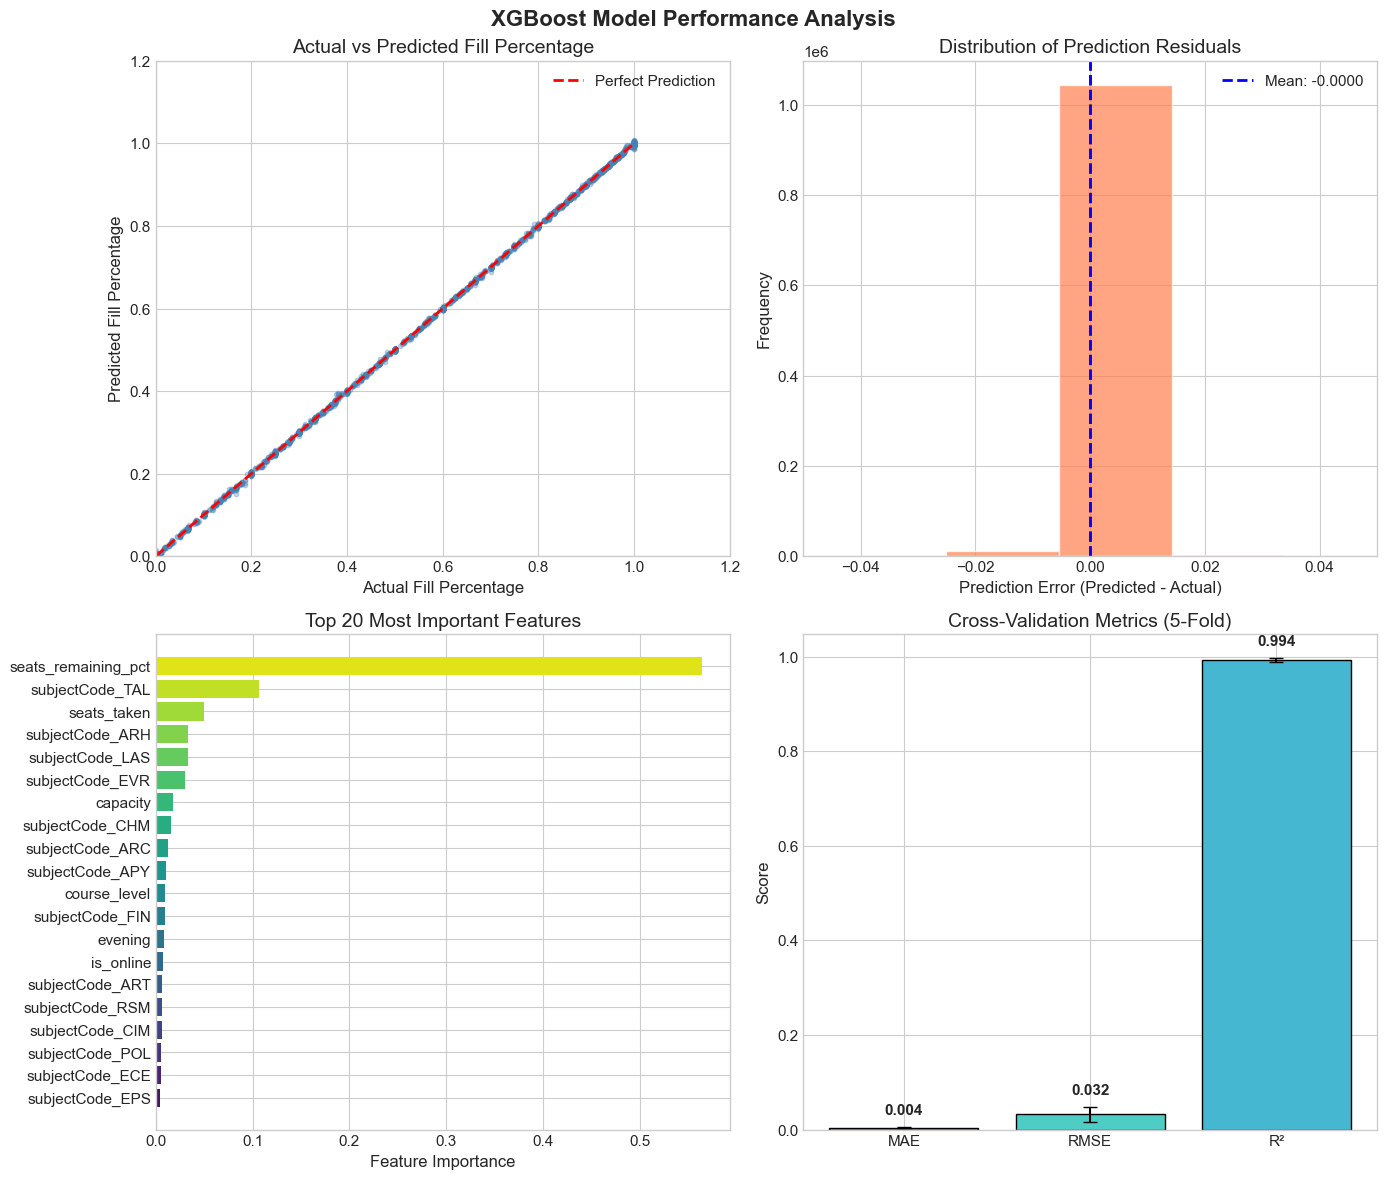


🎯 Model Performance Summary:
   Mean Absolute Error: 0.0038
   Root Mean Squared Error: 0.0320
   R² Score: 0.9938
   Within ±5% Tolerance: 99.83%


In [94]:
# ===============================================================
# VISUALIZATION 3: Model Performance & Feature Importance
# ===============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('XGBoost Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted scatter plot
ax7 = axes[0, 0]
sample_idx = np.random.choice(len(y), min(5000, len(y)), replace=False)
ax7.scatter(y.iloc[sample_idx], preds[sample_idx], alpha=0.3, s=10, c='steelblue')
ax7.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
ax7.set_xlabel('Actual Fill Percentage')
ax7.set_ylabel('Predicted Fill Percentage')
ax7.set_title('Actual vs Predicted Fill Percentage')
ax7.legend()
ax7.set_xlim(0, 1.2)
ax7.set_ylim(0, 1.2)

# 2. Residual distribution
ax8 = axes[0, 1]
residuals = preds - y.values
residuals_clean = residuals[(residuals > -0.5) & (residuals < 0.5)]
ax8.hist(residuals_clean, bins=50, color='coral', edgecolor='white', alpha=0.7)
ax8.axvline(0, color='red', linestyle='--', linewidth=2)
ax8.axvline(np.mean(residuals_clean), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_clean):.4f}')
ax8.set_xlabel('Prediction Error (Predicted - Actual)')
ax8.set_ylabel('Frequency')
ax8.set_title('Distribution of Prediction Residuals')
ax8.legend()
ax8.set_xlim(-0.05, 0.05)

# 3. Feature Importance (Top 20)
ax9 = axes[1, 0]
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True).tail(20)

colors = sns.color_palette("viridis", len(feature_importance))
ax9.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
ax9.set_xlabel('Feature Importance')
ax9.set_title('Top 20 Most Important Features')

# 4. Cross-Validation Scores
ax10 = axes[1, 1]
metrics = ['MAE', 'RMSE', 'R²']
cv_means = [np.mean(mae_scores), np.mean(rmse_scores), np.mean(r2_scores)]
cv_stds = [np.std(mae_scores), np.std(rmse_scores), np.std(r2_scores)]

x_pos = np.arange(len(metrics))
bars = ax10.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
ax10.set_xticks(x_pos)
ax10.set_xticklabels(metrics)
ax10.set_ylabel('Score')
ax10.set_title('Cross-Validation Metrics (5-Fold)')

# Add value labels on bars
for bar, mean, std in zip(bars, cv_means, cv_stds):
    ax10.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02, 
             f'{mean:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎯 Model Performance Summary:")
print(f"   Mean Absolute Error: {np.mean(mae_scores):.4f}")
print(f"   Root Mean Squared Error: {np.mean(rmse_scores):.4f}")
print(f"   R² Score: {np.mean(r2_scores):.4f}")
print(f"   Within ±5% Tolerance: {within_tol:.2%}")


In [95]:
# ===============================================================
# 9. Ranking Courses (CSC, ECE by 200/300/400 level)
# ===============================================================

# Get unique subject codes to see what's available
print("Available subject codes (sample):", list(popularity["subjectCode"].unique()[:20]))

target_subjects = ["CSC", "ECE"]
filtered = popularity[popularity["subjectCode"].isin(target_subjects)]
print(f"\nFiltered courses: CSC={len(filtered[filtered['subjectCode']=='CSC'])}, ECE={len(filtered[filtered['subjectCode']=='ECE'])}")

ranked_output = {}

# Note: course_level = catalogNumber // 100, so:
# - 200-level courses have course_level = 2
# - 300-level courses have course_level = 3
# - 400-level courses have course_level = 4
level_mapping = {200: 2, 300: 3, 400: 4}

for subj in target_subjects:
    subj_df = filtered[filtered["subjectCode"] == subj]
    ranked_output[subj] = {}

    for display_level, actual_level in level_mapping.items():
        lvl = subj_df[subj_df["course_level"] == actual_level]
        ranked_output[subj][display_level] = lvl.sort_values(
            "popularity_score", ascending=False
        ).head(10)  # top 10

# Print Rankings
print("\n=========== Top CSC 200-Level Courses ===========")
if len(ranked_output["CSC"][200]) > 0:
    print(ranked_output["CSC"][200][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No CSC 200-level courses found")

print("\n=========== Top CSC 300-Level Courses ===========")
if len(ranked_output["CSC"][300]) > 0:
    print(ranked_output["CSC"][300][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No CSC 300-level courses found")

print("\n=========== Top ECE 300-Level Courses ===========")
if len(ranked_output["ECE"][300]) > 0:
    print(ranked_output["ECE"][300][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No ECE 300-level courses found")

print("\n=========== Top ECE 400-Level Courses ===========")
if len(ranked_output["ECE"][400]) > 0:
    print(ranked_output["ECE"][400][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No ECE 400-level courses found")

# Export results
popularity.to_csv("course_popularity_scores.csv", index=False)
print(f"\n✓ Popularity scores saved to course_popularity_scores.csv")

Available subject codes (sample): [0, 'CTI', 'GNM', 'SAP', 'KIN', 'MDB', 'MCP', 'UMX', 'MIC', 'GSC', 'MGS', 'JMM', 'ATM', 'MSC', 'TAL', 'MBS', 'UMI', 'BMB', 'PTS', 'BST']

Filtered courses: CSC=60, ECE=77

=========== Top CSC 200-Level Courses ===========
      classNumber  catalogNumber  popularity_score  final_fill_rate
5172         9061          220.0          0.361528         0.700000
5171         9060          220.0          0.352859         0.666667
5173         9062          220.0          0.321822         0.566667
5170         9059          220.0          0.251079         0.333333
5186         9075          210.0          0.230663         0.266667

=========== Top CSC 300-Level Courses ===========
      classNumber  catalogNumber  popularity_score  final_fill_rate
5184         9073          329.0          0.637298         0.977778
5169         9058          317.0          0.543462         0.828125
5164         9053          322.0          0.480664         0.815385
5168         

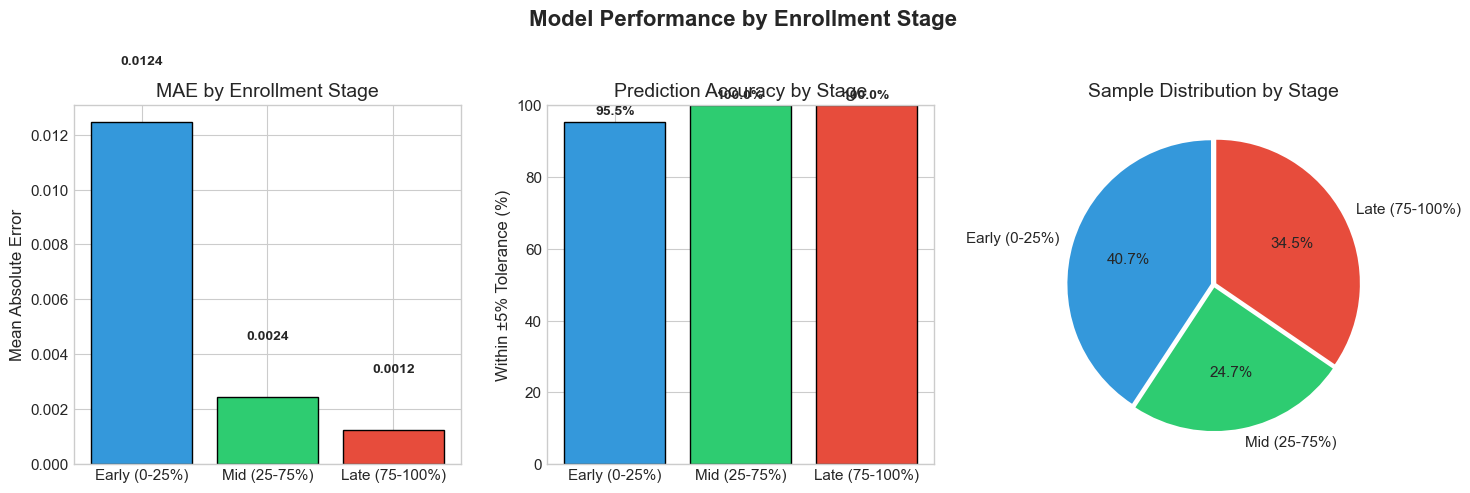


📊 Stage-Specific Insights:
   Early (0-25%): MAE=0.0124, Accuracy=95.5%, Samples=709,864
   Mid (25-75%): MAE=0.0024, Accuracy=100.0%, Samples=430,786
   Late (75-100%): MAE=0.0012, Accuracy=100.0%, Samples=601,901


In [57]:
# ===============================================================
# VISUALIZATION 4: Stage-Specific Performance Analysis
# ===============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance by Enrollment Stage', fontsize=16, fontweight='bold')

stage_metrics = {}
stages = ["Early (0-25%)", "Mid (25-75%)", "Late (75-100%)"]
stage_colors = ['#3498db', '#2ecc71', '#e74c3c']

for stage in stages:
    stage_data = eval_df[eval_df["stage"] == stage]
    if len(stage_data) > 0:
        stage_metrics[stage] = {
            'mae': stage_data["error"].mean(),
            'rmse': np.sqrt((stage_data["error"]**2).mean()),
            'within_tol': (stage_data["error"] <= 0.05).mean(),
            'count': len(stage_data)
        }

# 1. MAE by stage
ax1 = axes[0]
mae_values = [stage_metrics.get(s, {}).get('mae', 0) for s in stages]
bars1 = ax1.bar(stages, mae_values, color=stage_colors, edgecolor='black')
ax1.set_ylabel('Mean Absolute Error')
ax1.set_title('MAE by Enrollment Stage')
for bar, val in zip(bars1, mae_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Within Tolerance by stage
ax2 = axes[1]
tol_values = [stage_metrics.get(s, {}).get('within_tol', 0) * 100 for s in stages]
bars2 = ax2.bar(stages, tol_values, color=stage_colors, edgecolor='black')
ax2.set_ylabel('Within ±5% Tolerance (%)')
ax2.set_title('Prediction Accuracy by Stage')
ax2.set_ylim(0, 100)
for bar, val in zip(bars2, tol_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Sample distribution by stage
ax3 = axes[2]
counts = [stage_metrics.get(s, {}).get('count', 0) for s in stages]
wedges, texts, autotexts = ax3.pie(counts, labels=stages, autopct='%1.1f%%', 
                                    colors=stage_colors, startangle=90, explode=[0.02, 0.02, 0.02])
ax3.set_title('Sample Distribution by Stage')

plt.tight_layout()
plt.show()

print("\n📊 Stage-Specific Insights:")
for stage in stages:
    if stage in stage_metrics:
        m = stage_metrics[stage]
        print(f"   {stage}: MAE={m['mae']:.4f}, Accuracy={m['within_tol']:.1%}, Samples={m['count']:,}")


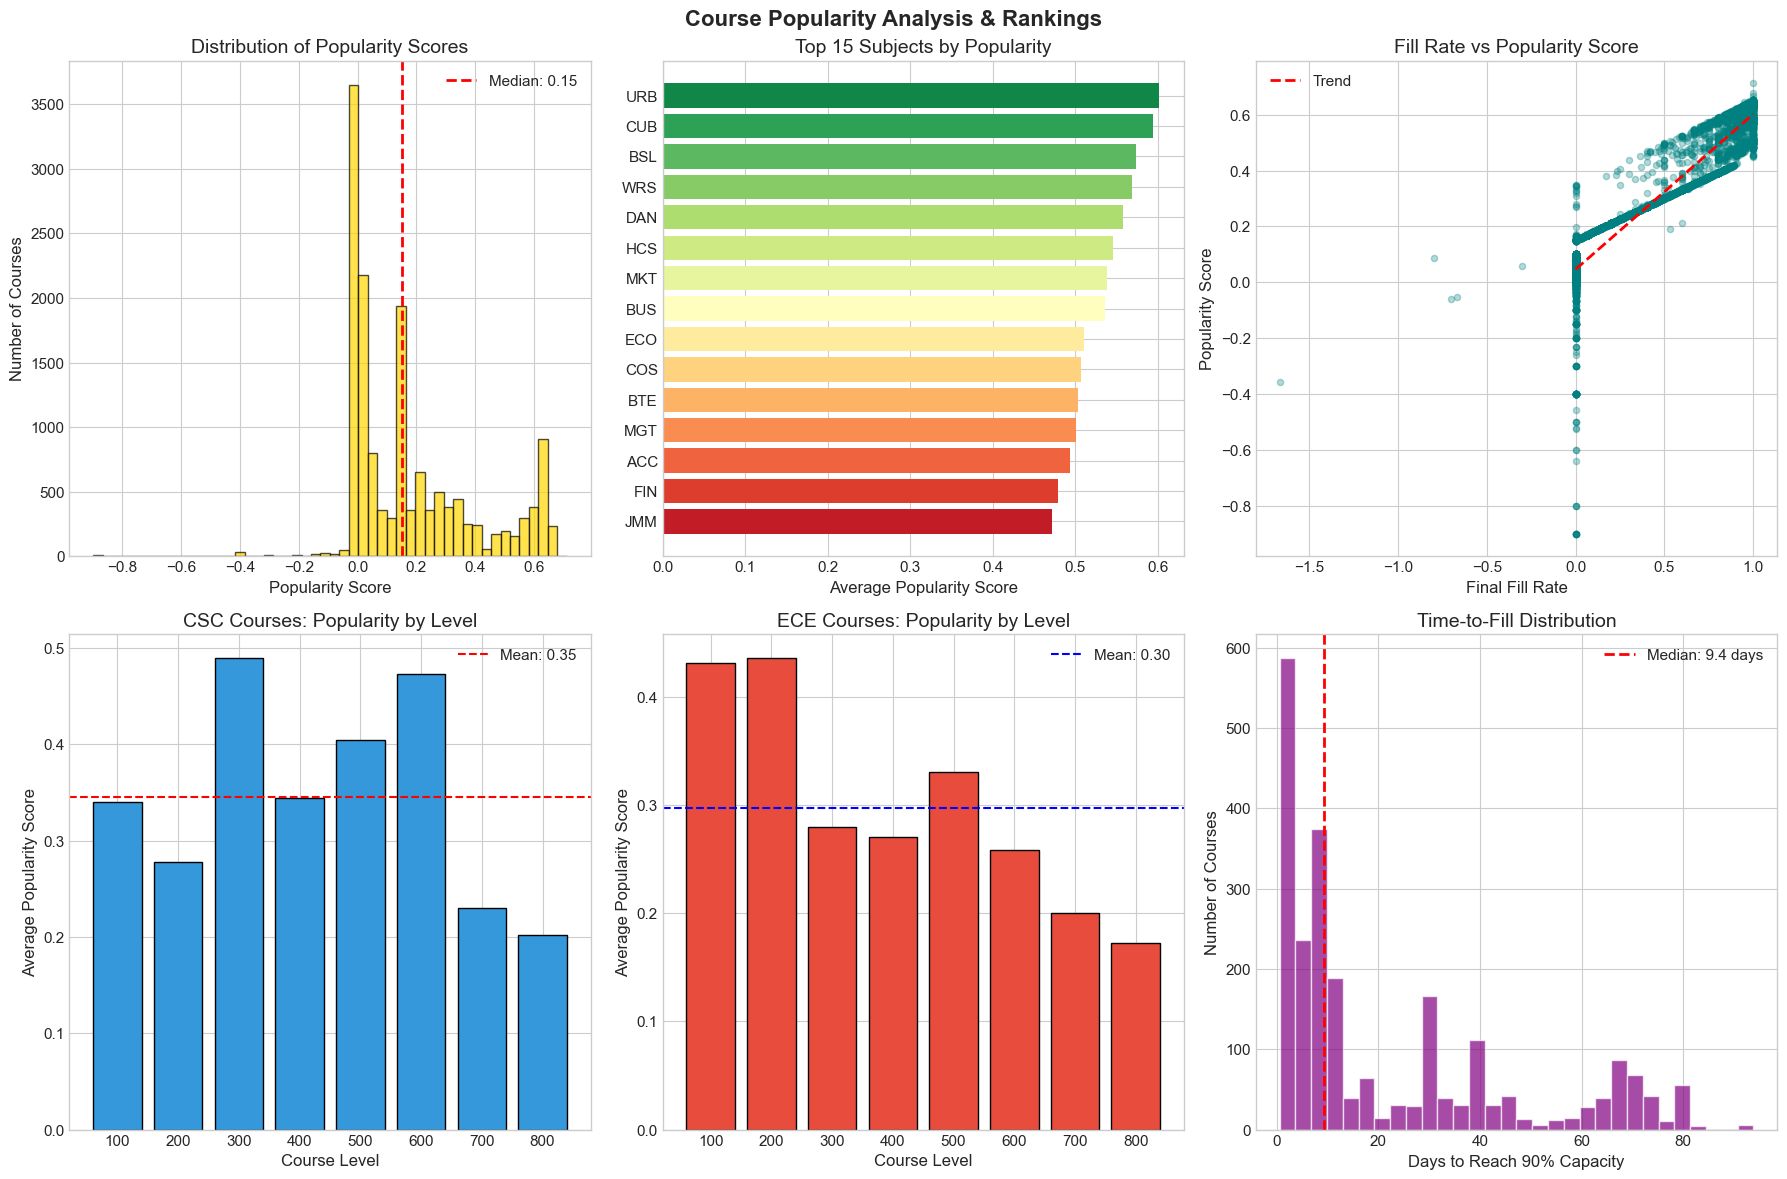


🏆 Popularity Summary:
   Total courses analyzed: 14,963
   CSC courses: 60
   ECE courses: 77
   Median popularity score: 0.150


In [96]:
# ===============================================================
# VISUALIZATION 5: Course Popularity & Rankings Analysis
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Course Popularity Analysis & Rankings', fontsize=16, fontweight='bold')

# 1. Distribution of popularity scores
ax1 = axes[0, 0]
pop_scores = popularity['popularity_score'].replace([np.inf, -np.inf], np.nan).dropna()
pop_scores = pop_scores[(pop_scores > -1) & (pop_scores < 2)]
ax1.hist(pop_scores, bins=50, color='gold', edgecolor='black', alpha=0.7)
ax1.axvline(pop_scores.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {pop_scores.median():.2f}')
ax1.set_xlabel('Popularity Score')
ax1.set_ylabel('Number of Courses')
ax1.set_title('Distribution of Popularity Scores')
ax1.legend()

# 2. Top 15 subjects by average popularity
ax2 = axes[0, 1]
subject_pop = popularity.groupby('subjectCode')['popularity_score'].mean()
subject_pop = subject_pop.replace([np.inf, -np.inf], np.nan).dropna()
subject_pop = subject_pop[(subject_pop > -1) & (subject_pop < 2)].sort_values(ascending=False).head(15)
colors = sns.color_palette("RdYlGn_r", len(subject_pop))
bars = ax2.barh(subject_pop.index, subject_pop.values, color=colors)
ax2.set_xlabel('Average Popularity Score')
ax2.set_title('Top 15 Subjects by Popularity')
ax2.invert_yaxis()

# 3. Fill rate vs Popularity correlation
ax3 = axes[0, 2]
pop_clean = popularity[['final_fill_rate', 'popularity_score']].replace([np.inf, -np.inf], np.nan).dropna()
pop_clean = pop_clean[(pop_clean['popularity_score'] > -1) & (pop_clean['popularity_score'] < 2)]
ax3.scatter(pop_clean['final_fill_rate'], pop_clean['popularity_score'], alpha=0.3, s=20, c='teal')
ax3.set_xlabel('Final Fill Rate')
ax3.set_ylabel('Popularity Score')
ax3.set_title('Fill Rate vs Popularity Score')
# Add trend line
z = np.polyfit(pop_clean['final_fill_rate'], pop_clean['popularity_score'], 1)
p = np.poly1d(z)
ax3.plot([0, 1], [p(0), p(1)], "r--", linewidth=2, label='Trend')
ax3.legend()

# 4. CSC Courses by Level
ax4 = axes[1, 0]
csc_pop = popularity[popularity['subjectCode'] == 'CSC']
csc_by_level = csc_pop.groupby('course_level')['popularity_score'].mean()
csc_by_level = csc_by_level.replace([np.inf, -np.inf], np.nan).dropna()
csc_by_level = csc_by_level[(csc_by_level.index >= 1) & (csc_by_level.index <= 8)]
ax4.bar([f'{int(x)}00' for x in csc_by_level.index], csc_by_level.values, color='#3498db', edgecolor='black')
ax4.set_xlabel('Course Level')
ax4.set_ylabel('Average Popularity Score')
ax4.set_title('CSC Courses: Popularity by Level')
ax4.axhline(csc_by_level.mean(), color='red', linestyle='--', label=f'Mean: {csc_by_level.mean():.2f}')
ax4.legend()

# 5. ECE Courses by Level
ax5 = axes[1, 1]
ece_pop = popularity[popularity['subjectCode'] == 'ECE']
ece_by_level = ece_pop.groupby('course_level')['popularity_score'].mean()
ece_by_level = ece_by_level.replace([np.inf, -np.inf], np.nan).dropna()
ece_by_level = ece_by_level[(ece_by_level.index >= 1) & (ece_by_level.index <= 8)]
ax5.bar([f'{int(x)}00' for x in ece_by_level.index], ece_by_level.values, color='#e74c3c', edgecolor='black')
ax5.set_xlabel('Course Level')
ax5.set_ylabel('Average Popularity Score')
ax5.set_title('ECE Courses: Popularity by Level')
ax5.axhline(ece_by_level.mean(), color='blue', linestyle='--', label=f'Mean: {ece_by_level.mean():.2f}')
ax5.legend()

# 6. Time to Fill Distribution
ax6 = axes[1, 2]
ttf = popularity['time_to_fill_days'].replace([np.inf, -np.inf], np.nan).dropna()
ttf = ttf[ttf > 0]
if len(ttf) > 0:
    ax6.hist(ttf, bins=30, color='purple', edgecolor='white', alpha=0.7)
    ax6.axvline(ttf.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {ttf.median():.1f} days')
    ax6.set_xlabel('Days to Reach 90% Capacity')
    ax6.set_ylabel('Number of Courses')
    ax6.set_title('Time-to-Fill Distribution')
    ax6.legend()
else:
    ax6.text(0.5, 0.5, 'No courses reached 90%', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Time-to-Fill Distribution')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n🏆 Popularity Summary:")
print(f"   Total courses analyzed: {len(popularity):,}")
print(f"   CSC courses: {len(csc_pop)}")
print(f"   ECE courses: {len(ece_pop)}")
print(f"   Median popularity score: {pop_scores.median():.3f}")


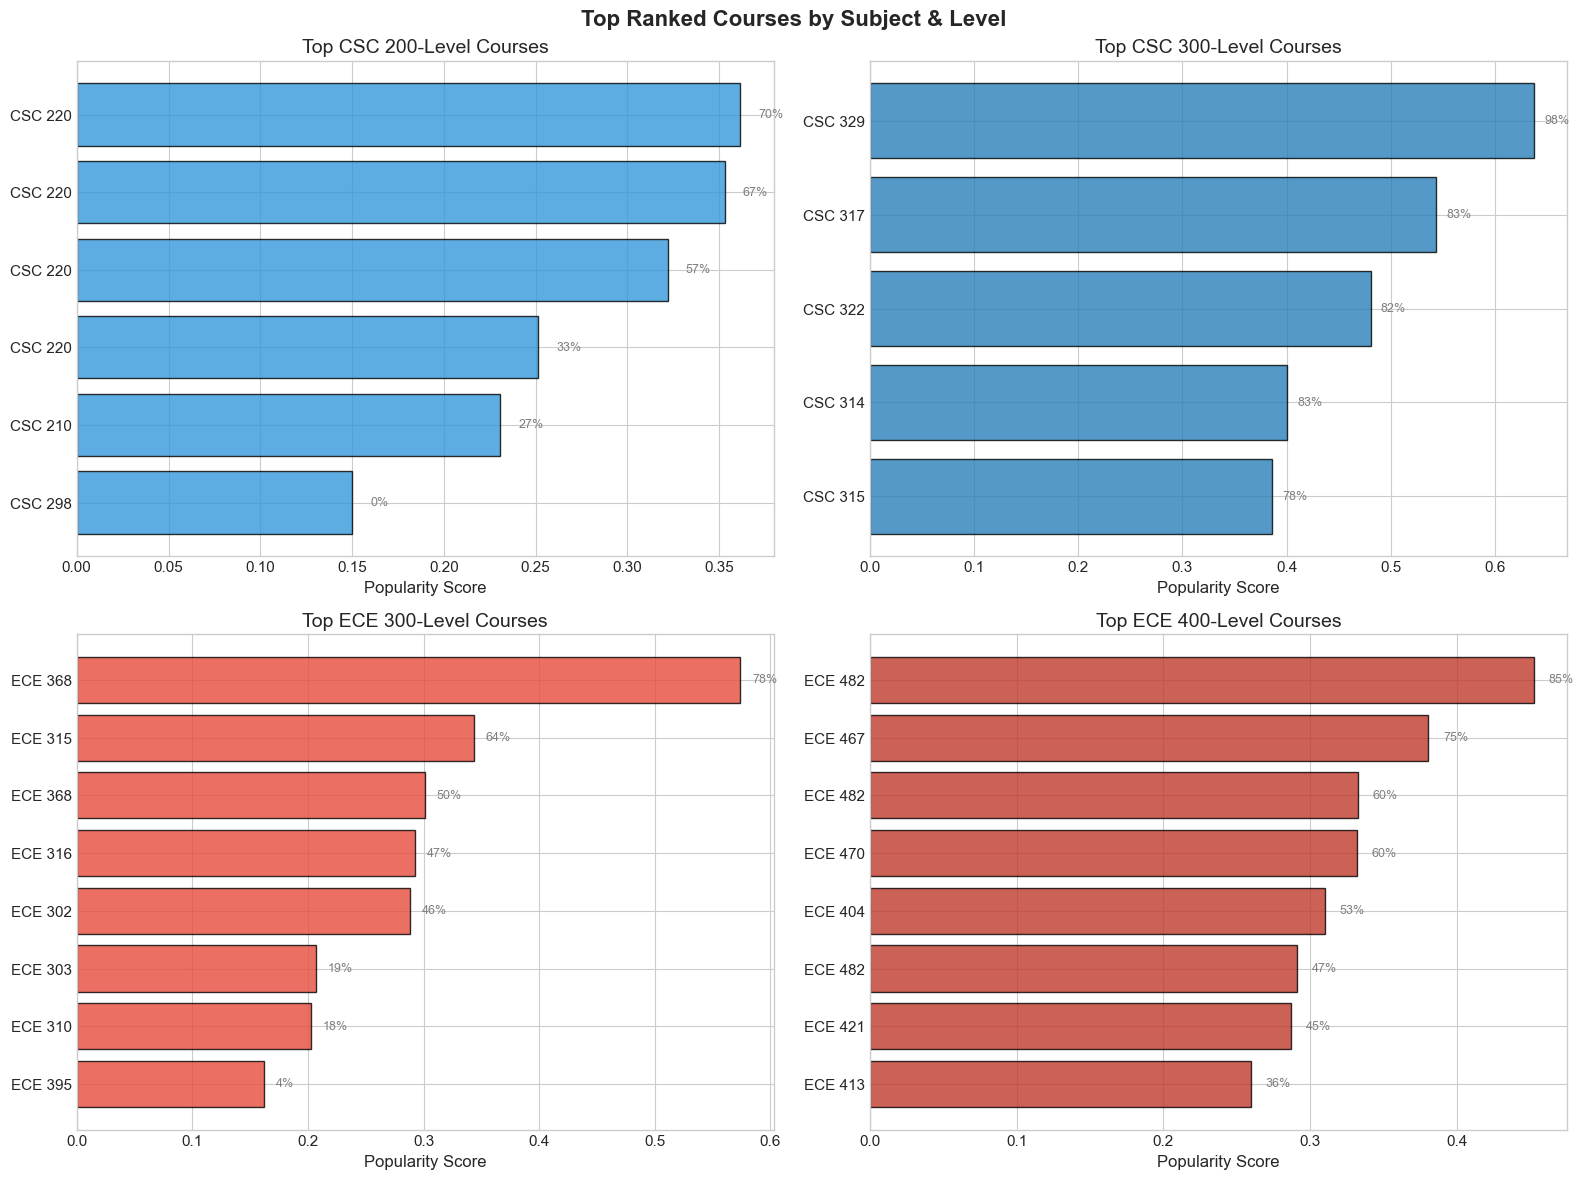


📋 TOP COURSE RANKINGS SUMMARY

CSC Department:
----------------------------------------

  200-Level Top 3:
    • CSC 220: Score=0.362, Fill=70%
    • CSC 220: Score=0.353, Fill=67%
    • CSC 220: Score=0.322, Fill=57%

  300-Level Top 3:
    • CSC 329: Score=0.637, Fill=98%
    • CSC 317: Score=0.543, Fill=83%
    • CSC 322: Score=0.481, Fill=82%

  400-Level Top 3:
    • CSC 423: Score=0.553, Fill=80%
    • CSC 410: Score=0.534, Fill=100%
    • CSC 411: Score=0.465, Fill=77%

ECE Department:
----------------------------------------

  200-Level Top 3:
    • ECE 205: Score=0.635, Fill=97%
    • ECE 218: Score=0.596, Fill=93%
    • ECE 211: Score=0.592, Fill=86%

  300-Level Top 3:
    • ECE 368: Score=0.574, Fill=78%
    • ECE 315: Score=0.343, Fill=64%
    • ECE 368: Score=0.302, Fill=50%

  400-Level Top 3:
    • ECE 482: Score=0.452, Fill=85%
    • ECE 467: Score=0.380, Fill=75%
    • ECE 482: Score=0.332, Fill=60%


In [97]:
# ===============================================================
# VISUALIZATION 6: Top Course Rankings Visualization
# ===============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Top Ranked Courses by Subject & Level', fontsize=16, fontweight='bold')

level_mapping = {200: 2, 300: 3, 400: 4}

# Function to create ranking bar chart
def plot_top_courses(ax, subject, level, color):
    actual_level = level_mapping[level]
    subj_df = popularity[(popularity['subjectCode'] == subject) & (popularity['course_level'] == actual_level)]
    subj_df = subj_df.replace([np.inf, -np.inf], np.nan)
    subj_df = subj_df.dropna(subset=['popularity_score'])
    top_courses = subj_df.sort_values('popularity_score', ascending=False).head(8)
    
    if len(top_courses) > 0:
        y_pos = np.arange(len(top_courses))
        bars = ax.barh(y_pos, top_courses['popularity_score'].values, color=color, edgecolor='black', alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"{subject} {int(c)}" for c in top_courses['catalogNumber']])
        ax.set_xlabel('Popularity Score')
        ax.set_title(f'Top {subject} {level}-Level Courses')
        ax.invert_yaxis()
        
        # Add fill rate as text
        for i, (bar, fr) in enumerate(zip(bars, top_courses['final_fill_rate'])):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{fr:.0%}', va='center', fontsize=9, color='gray')
    else:
        ax.text(0.5, 0.5, f'No {subject} {level}-level courses', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Top {subject} {level}-Level Courses')

# Plot top courses for each subject/level combination
plot_top_courses(axes[0, 0], 'CSC', 200, '#3498db')
plot_top_courses(axes[0, 1], 'CSC', 300, '#2980b9')
plot_top_courses(axes[1, 0], 'ECE', 300, '#e74c3c')
plot_top_courses(axes[1, 1], 'ECE', 400, '#c0392b')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("📋 TOP COURSE RANKINGS SUMMARY")
print("="*70)

for subject in ['CSC', 'ECE']:
    print(f"\n{subject} Department:")
    print("-" * 40)
    for display_level, actual_level in level_mapping.items():
        subj_df = popularity[(popularity['subjectCode'] == subject) & (popularity['course_level'] == actual_level)]
        subj_df = subj_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['popularity_score'])
        if len(subj_df) > 0:
            top = subj_df.sort_values('popularity_score', ascending=False).head(3)
            print(f"\n  {display_level}-Level Top 3:")
            for _, row in top.iterrows():
                print(f"    • {subject} {int(row['catalogNumber'])}: Score={row['popularity_score']:.3f}, Fill={row['final_fill_rate']:.0%}")
